# Classificador de Imagens usando TensorFlow Estimators

Neste notebook iremos implementadar um modelo para classificação de imagens. Classificação é uma das "tarefas" em que podemos utilizar Machine Learning, nesta tarefa o ensino é **supervisionado**, em outras palavras nós vamos ensinar ao modelo através de exemplos com gabarito.

Nosso modelo deverá receber imagens do [dataset MNIST](https://en.wikipedia.org/wiki/MNIST_database) e identificar a que **classe** (dígito de 0 a 9) estas imagens pertencem.

## Dados

Os dados foram retirados da base de dados [MNIST](https://en.wikipedia.org/wiki/MNIST_database). Este dataset já vem separado em treino e teste e contém 60.000 imagens de treino e 10.000 imagens de teste. Cada imagem tem dimensões 28x28, em preto e branco e representa um dígito desenhado a mão. Além disso cada imagem acompanha uma label que nos diz qual dígito essa imagem representa, de modo que este dataset é perfeito para classificação.

## Modelo

Iremos utilizar diferentes modelos com diferentes níveis de complexidade.

## Créditos

Essa atividade é baseada no notebook encontrado [aqui](https://github.com/mari-linhares/tensorflow-workshop/blob/master/workshops/cdnextcon_2017/Walk-Through.ipynb).

Além disso para mais informações sobre Estimators [este](goo.gl/DBeUkN) é um ótimo material para mais detalhes!

Obrigada a todos os envolvidos!

## Dependências

In [3]:
# Compatibilidade entre Python 2 e Python 3
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# TensorFlow
import tensorflow as tf
# MNIST
from tensorflow.examples.tutorials.mnist import input_data

tf.logging.set_verbosity(tf.logging.INFO)  # Permitindo visualização de logs

# Bibliotecas auxiliares
import numpy as np  # manipular vetores
import matplotlib.pyplot as plt  # plotar imagens
%matplotlib inline

# IMPORTANTE: essa linha garante que os números gerados aleatoriamente são previsíveis
np.random.seed(0)

print ('Sua versão do TensorFlow:', tf.__version__)
print ('Recomenda-se para esta atividade uma versão >= 1.4.0')

Sua versão do TensorFlow: 1.4.1
Recomenda-se para esta atividade uma versão >= 1.4.0


## Buscando os Dados

In [4]:
# Buscando dados de treino e teste
mnist = input_data.read_data_sets('/tmp/MNIST/', one_hot=True)

# x_treino: imagens, y_treino: labels
x_treino = mnist.train.images
y_treino = mnist.train.labels
x_teste = mnist.test.images
y_teste = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/MNIST/t10k-labels-idx1-ubyte.gz


## Visualizando os dados

Após manipular ou modificar os dados é sempre importante garantir que os dados estão no formato esperado e não foram corrompidos ou alterados indevidamente. Para isto vamos escolher algumas imagens do conjunto de treino aleatoriamente e verificá-las.

> IMPORTANTE: para modelos reais é importante garantir a qualidade e integridade dos dados com maior rigor já que é fundamental a "saúde" dos dados para se obter um bom modelo.


In [5]:
print ('Formato das imagens de treino:', x_treino.shape)
print ('Número de labels de treino:', y_treino.shape[0])
print ('-' * 50)
print ('Formato das imagens de teste:', x_teste.shape)
print ('Número de labels de teste:', y_teste.shape[0])

Formato das imagens de treino: (55000, 784)
Número de labels de treino: 55000
--------------------------------------------------
Formato das imagens de teste: (10000, 784)
Número de labels de teste: 10000


Temos apenas 550000 dados de treino, porque nesta versão do MNIST 5000 exemplos foram separados para serem usados como avaliação. Além disso vemos o valor 784, pois as imagens são 28x28 píxels, ou de outra forma 784 píxels.

Exemplos de 5 imagens da base de treino


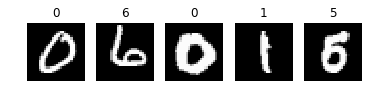

In [11]:
def visualizar_dados_treino(num_dados):
    '''Essa função apresenta alguns dados de treino (imagens, labels) escolhidos aleatoriamente.
       Parâmetros:
           num_dados (int): número de dados que serão apresentados 
    '''

    print('Exemplos de %d imagens da base de treino' % num_dados)
    
    # Escolhemos índices aleatórios
    random_indices = np.random.randint(0, x_treino.shape[0], num_dados)
    
    # Buscando imagens e labels
    imagens = x_treino[random_indices]
    labels = y_treino[random_indices]
    
    # Plottando imagens
    for index, (img, label) in enumerate(zip(imagens, labels)):
        plt.subplot(2, num_dados, index + 1)
        plt.axis('off')
        plt.imshow(np.reshape(img, (28, 28)), cmap='gray', interpolation='nearest')
        plt.title('%i' % np.argmax(label))
    plt.show()

visualizar_dados_treino(5)

## Implementando o modelo

### Input function

In [12]:
# Input function de treino
mnist_treino_input = tf.estimator.inputs.numpy_input_fn(
  # os dados devem ser passados como um dicionário, contendo cada feature
  # como nossa entrada é uma imagem, ou seja, apenas uma feature
  # temos apenas uma chave no dicionário 'x' cujo valor são as imagens  
  {'x': np.array(x_treino, dtype=np.float32) },
  # os labels esperados para numpy_input_fn é um vetor numpy
  np.array(y_treino, dtype=np.int32),
  # sempre importanto "misturar" os dados de treino
  shuffle=True,
  # este parâmetro = None, implica em repetir os dados de forma "circular"
  # iremos controlar o número de interações durante o treino do modelo.
  num_epochs=None)

# Input function de teste
mnist_teste_input = tf.estimator.inputs.numpy_input_fn(
  # da mesma forma os dados devem ser passados como um dicionário
  {'x':np.array(x_teste, dtype=np.float32)},
  # labels
  np.array(y_teste, dtype=np.int32),
  # misturando os dados
  shuffle=True,
  # sem repetir os dados
  num_epochs=1)

### Model function

In [13]:
def build_cnn(input_layer, mode):
    with tf.name_scope("conv1"):  
      conv1 = tf.layers.conv2d(inputs=input_layer,filters=32, kernel_size=[5, 5],
                               padding='same', activation=tf.nn.relu)

    with tf.name_scope("pool1"):  
      pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    with tf.name_scope("conv2"):  
      conv2 = tf.layers.conv2d(inputs=pool1,filters=64, kernel_size=[5, 5],
                               padding='same', activation=tf.nn.relu)

    with tf.name_scope("pool2"):  
      pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    with tf.name_scope("dense"):  
      pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
      dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    with tf.name_scope("dropout"): 
      # dropout apenas se estivermos treinando
      # você pode aprender mais sobre dropout e CNNs aqui:
      # https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout 
      is_training_mode = mode == tf.estimator.ModeKeys.TRAIN
      dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=is_training_mode)

    logits = tf.layers.dense(inputs=dropout, units=10)

    return logits

def model_fn(features, labels, mode, params):
  # Deve conter os seguintes passos:
  
  # 1. Definir o modelo via TF
  if params['model'] == 'simples':
    output = tf.layers.dense(inputs=features['x'], units=10)
  elif params['model'] == 'CNN':
    # mudando a shape da entrada para a esperada pela CNN
    input_layer = tf.reshape(features['x'], [-1, 28, 28, 1])
    output = build_cnn(input_layer, mode)
  
  
  # 2. Definir como gerar predições
  predicoes = {
      'classes': tf.argmax(input=output, axis=1),
      'probabilidades': tf.nn.softmax(output, name='softmax_tensor')
  }
  
  # Se estamos realizando predição precisamos apenas especificar estas operações ;)
  if mode == tf.estimator.ModeKeys.PREDICT:
    # Return an EstimatorSpec object
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predicoes)
  
  
  # 3. Definir a loss function para treino e avaliação
  # loss => erro, como calcular nosso erro?
  loss =  tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=output)


  # Se estamos treinando precisamos definir como otimizar nosso modelo
  # Para o Estimator esta definição é chamada train_op
  if mode == tf.estimator.ModeKeys.TRAIN:
    
    # 4. Definir como otimizar o modelo (optimizer)
    # como otimizar nosso modelo utilizando o erro que calculamos?
    # Neste exemplo estamos usando um algoritmo de otimizacao chamado Adam
    train_op = tf.contrib.layers.optimize_loss(
      loss=loss,
      global_step=tf.train.get_global_step(),
      learning_rate=params['learning_rate'],
      optimizer=params['optimizer'])
    
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predicoes,
                                      loss=loss, train_op=train_op)
  
  
  # 5. Definir métricas para avaliação
  eval_metric_ops = {
      'acuracia': tf.metrics.accuracy(
          tf.argmax(input=output, axis=1),
          tf.argmax(input=labels, axis=1))
  }
  
  # 6. Retornar um EstimatorSpec definindo os passos acima
  return tf.estimator.EstimatorSpec(mode=mode, predictions=predicoes,
                                      loss=loss, eval_metric_ops=eval_metric_ops)


## Treinando e Avaliando o Modelo Simples

In [19]:
# Criando nosso modelo simples
model_params = {
  'optimizer': 'Adam',
  'learning_rate': 1e-4,
  'model': 'simples'
}

# model_dir indica onde salvar os dados do modelo (pesos, logs, arquivos tensorboard)
modelo_simples = tf.estimator.Estimator(model_fn=model_fn, params=model_params, model_dir='output/simples/')

# Treino por 10000 passos
modelo_simples.train(input_fn=mnist_treino_input, steps=10000)

# Avaliando modelo
print (modelo_simples.evaluate(input_fn=mnist_teste_input))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff14ab0af50>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'output/simples/', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into output/simples/model.ckpt.
INFO:tensorflow:loss = 2.47138, step = 1
INFO:tensorflow:global_step/sec: 385.941
INFO:tensorflow:loss = 2.06453, step = 101 (0.260 sec)
INFO:tensorflow:global_step/sec: 412.805
INFO:tensorflow:loss = 1.77982, step = 201 (0.243 sec)
INFO:tensorflow:global_step/sec: 371.71
INFO:tensorflow:loss = 1.40163, 

INFO:tensorflow:loss = 0.273625, step = 7701 (0.300 sec)
INFO:tensorflow:global_step/sec: 391.902
INFO:tensorflow:loss = 0.288287, step = 7801 (0.256 sec)
INFO:tensorflow:global_step/sec: 418.964
INFO:tensorflow:loss = 0.442449, step = 7901 (0.238 sec)
INFO:tensorflow:global_step/sec: 434.635
INFO:tensorflow:loss = 0.287631, step = 8001 (0.230 sec)
INFO:tensorflow:global_step/sec: 429.564
INFO:tensorflow:loss = 0.278402, step = 8101 (0.233 sec)
INFO:tensorflow:global_step/sec: 446.397
INFO:tensorflow:loss = 0.393412, step = 8201 (0.224 sec)
INFO:tensorflow:global_step/sec: 416.034
INFO:tensorflow:loss = 0.296046, step = 8301 (0.240 sec)
INFO:tensorflow:global_step/sec: 427.286
INFO:tensorflow:loss = 0.4378, step = 8401 (0.234 sec)
INFO:tensorflow:global_step/sec: 438.579
INFO:tensorflow:loss = 0.412753, step = 8501 (0.228 sec)
INFO:tensorflow:global_step/sec: 422.31
INFO:tensorflow:loss = 0.316778, step = 8601 (0.237 sec)
INFO:tensorflow:global_step/sec: 422.344
INFO:tensorflow:loss = 

## Treinando e Avaliando a CNN

In [20]:
model_params['model'] = 'CNN'
modelo_cnn = tf.estimator.Estimator(model_fn=model_fn, params=model_params, model_dir='output/cnn/')

# Treino por 10000 passos
modelo_cnn.train(input_fn=mnist_treino_input, steps=10000)

# Avaliando modelo
print (modelo_cnn.evaluate(input_fn=mnist_teste_input))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff14ae5ccd0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'output/cnn/', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from output/cnn/model.ckpt-1
INFO:tensorflow:Saving checkpoints for 2 into output/cnn/model.ckpt.
INFO:tensorflow:loss = 2.29218, step = 2
INFO:tensorflow:global_step/sec: 1.87363
INFO:tensorflow:loss = 0.537803, step = 102 (53.373 sec)
INFO:tensorflow:global_step/sec: 2.01702
INFO:tensorflow:loss = 0.258778, step = 202 (49.580 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 2.00402
INFO:tensorflow:loss = 0.0151187, step = 7102 (49.900 sec)
INFO:tensorflow:global_step/sec: 2.02863
INFO:tensorflow:loss = 0.00841472, step = 7202 (49.294 sec)
INFO:tensorflow:global_step/sec: 2.08032
INFO:tensorflow:loss = 0.0186681, step = 7302 (48.069 sec)
INFO:tensorflow:global_step/sec: 2.07903
INFO:tensorflow:loss = 0.00432059, step = 7402 (48.100 sec)
INFO:tensorflow:global_step/sec: 2.07924
INFO:tensorflow:loss = 0.0381186, step = 7502 (48.094 sec)
INFO:tensorflow:global_step/sec: 2.12956
INFO:tensorflow:loss = 0.017439, step = 7602 (46.958 sec)
INFO:tensorflow:global_step/sec: 2.12898
INFO:tensorflow:loss = 0.0237805, step = 7702 (46.971 sec)
INFO:tensorflow:Saving checkpoints for 7720 into output/cnn/model.ckpt.
INFO:tensorflow:global_step/sec: 2.11463
INFO:tensorflow:loss = 0.0539274, step = 7802 (47.290 sec)
INFO:tensorflow:global_step/sec: 1.92965
INFO:tensorflow:loss = 0.00837943, step = 7902 (51.823 sec)
INFO:tensorflow:global_ste

## Exercício

Implementar a input function para predição de uma imagem e realizar tal predição, um exemplo de como fazer isso para outra base de dados pode ser visto [aqui](https://github.com/mari-linhares/tensorflow-brasil/blob/master/classificador-cachorros-gatos-estimator/classificador-de-imagens-estimators.ipynb).